In [6]:
# =============================================================================
# Predictive Modeling of the Calgary Real Estate Market
#
# Author: Michael Baloun
# Date: October 5, 2025
#
# This notebook details the end-to-end process of building a machine
# learning model to predict residential property assessed values in Calgary.
# =============================================================================

# --- 1. SETUP AND LIBRARIES ---
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import xgboost as xgb
from shapely.wkt import loads
import warnings

# Suppress all warnings for a clean final output
warnings.filterwarnings('ignore')
# Set plot style
sns.set_style("whitegrid")

# --- 2. DATA LOADING ---
print("Mounting Google Drive and loading data...")
drive.mount('/content/drive', force_remount=True)
base_path = '/content/drive/My Drive/MIAI_Project/data/'
calgary_file = 'Total_Property_Assessed_Value.csv'
calgary_df = pd.read_csv(base_path + calgary_file, low_memory=False)
print("Data loading complete.")

# --- 3. DATA CLEANING & FEATURE ENGINEERING ---
print("Cleaning data and engineering features...")
# Filter for residential properties
residential_df = calgary_df[calgary_df['ASSESSMENT_CLASS_DESCRIPTION'] == 'Residential'].copy()

# Clean key numerical columns
columns_to_clean = ['ASSESSED_VALUE', 'LAND_SIZE_SM']
for col in columns_to_clean:
    if residential_df[col].dtype == 'object':
        residential_df[col] = residential_df[col].str.replace(',', '')
    residential_df[col] = pd.to_numeric(residential_df[col], errors='coerce')

# Engineer geospatial features from polygon data
def get_centroid(polygon_wkt):
    try:
        polygon = loads(polygon_wkt)
        return polygon.centroid.x, polygon.centroid.y
    except:
        return None, None
centroids = residential_df['MULTIPOLYGON'].apply(get_centroid)
residential_df['longitude'] = centroids.apply(lambda x: x[0])
residential_df['latitude'] = centroids.apply(lambda x: x[1])

# --- 4. FINAL DATASET PREPARATION ---
# Select final features
features_to_use = [
    'YEAR_OF_CONSTRUCTION', 'LAND_SIZE_SM', 'ROLL_YEAR',
    'longitude', 'latitude', 'ASSESSED_VALUE'
]
model_df = residential_df[features_to_use].copy()
model_df.dropna(inplace=True)

# Filter out extreme outliers
rows_before = len(model_df)
model_df = model_df[model_df['ASSESSED_VALUE'] < 3000000]
rows_after = len(model_df)
outliers_removed = rows_before - rows_after
percentage_removed = (outliers_removed / rows_before) * 100

# --- 5. MODEL TRAINING ---
print("Training the XGBoost model...")
# Define Features (X) and Target (y)
X = model_df.drop('ASSESSED_VALUE', axis=1)
y = model_df['ASSESSED_VALUE']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgbr = xgb.XGBRegressor(n_estimators=100, max_depth=5, objective='reg:squarederror', random_state=42, device="cuda")
xgbr.fit(X_train, y_train)
print("Model training complete.")

# --- 6. MODEL EVALUATION ---
print("\n--- Final Model Performance ---")
# Evaluate on both Train and Test Sets
predictions_test = xgbr.predict(X_test)
predictions_train = xgbr.predict(X_train)
score_r2_test = r2_score(y_test, predictions_test)
score_mae_test = mean_absolute_error(y_test, predictions_test)
score_rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))
score_r2_train = r2_score(y_train, predictions_train)
score_mae_train = mean_absolute_error(y_train, predictions_train)
score_rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))

# Print a comparison
print("\n--- Test Set (Unseen Data) ---")
print(f"R-squared: {score_r2_test:.2f}")
print(f"MAE: ${score_mae_test:,.2f}")
print(f"RMSE: ${score_rmse_test:,.2f}")
print("\n--- Train Set (Seen Data) ---")
print(f"R-squared: {score_r2_train:.2f}")
print(f"MAE: ${score_mae_train:,.2f}")
print(f"RMSE: ${score_rmse_train:,.2f}")
print("-----------------------------")
print(f"\nNote: {outliers_removed:,} outlier properties ({percentage_removed:.2f}%) were removed to train the model on the core market.")


Mounting Google Drive and loading data...
Mounted at /content/drive
Data loading complete.
Cleaning data and engineering features...
Training the XGBoost model...
Model training complete.

--- Final Model Performance ---

--- Test Set (Unseen Data) ---
R-squared: 0.73
MAE: $91,940.28
RMSE: $156,499.15

--- Train Set (Seen Data) ---
R-squared: 0.73
MAE: $91,661.78
RMSE: $155,673.06
-----------------------------

Note: 5,569 outlier properties (0.26%) were removed to train the model on the core market.


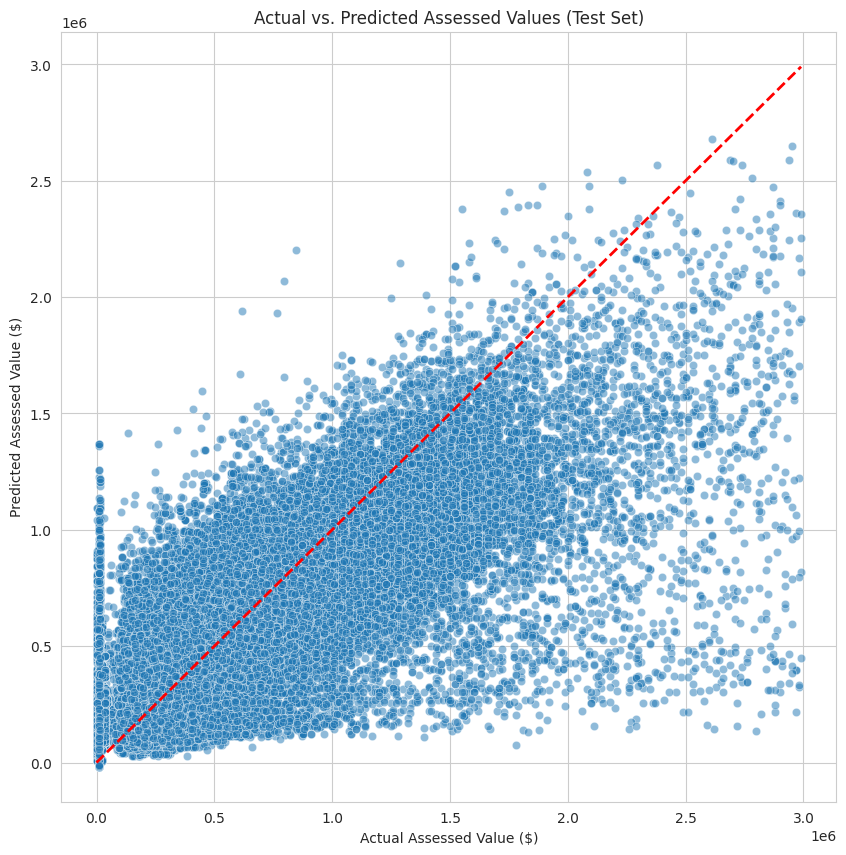

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot 1: Actual vs. Predicted Values
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=predictions_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')
plt.title('Actual vs. Predicted Assessed Values (Test Set)')
plt.xlabel('Actual Assessed Value ($)')
plt.ylabel('Predicted Assessed Value ($)')
plt.show()


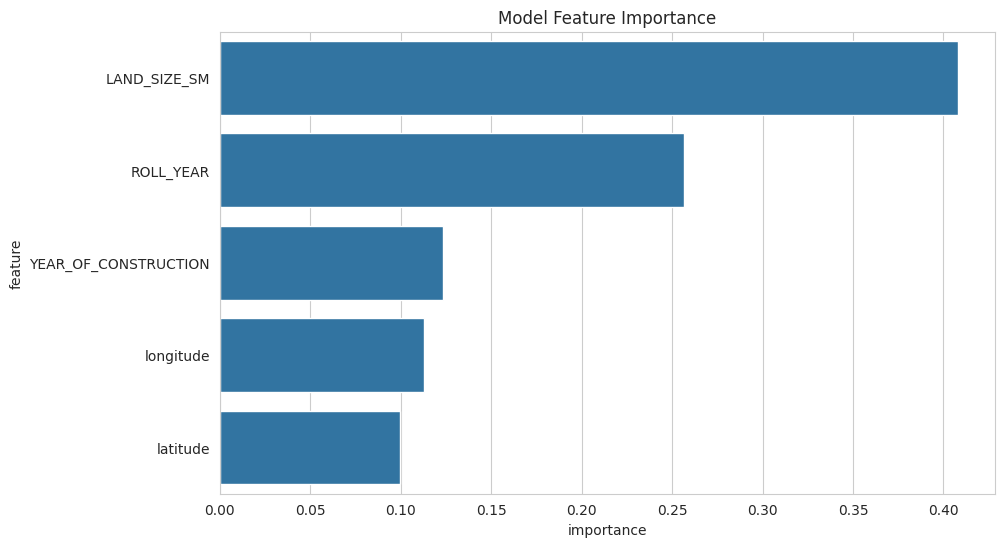

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot 2: Feature Importance
importances = xgbr.feature_importances_
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Model Feature Importance')
plt.show()

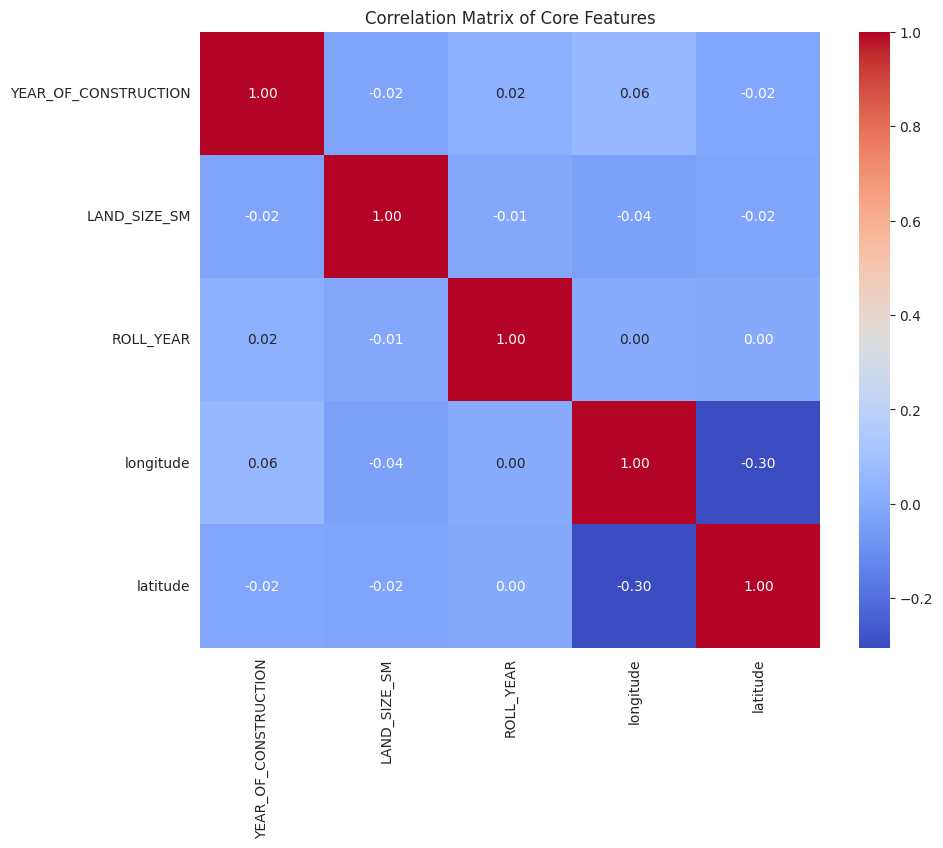

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot 3: Correlation Matrix of Features
corr_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Core Features')
plt.show()